---
title: "Auto Clipper Redux"
author: "Ali Zaidi"
date: "2025-11-26"
categories: [Data Engineering, Automated Annotation]
description: "Now that we have new data coming in lets clip every swing and find our labels"
format:
  html:
    code-fold: true
jupyter: python3
---

In [1]:
#| include: false 
from fastai.vision.all import *
from eagle_swing.clipper import *
from eagle_swing.plot import *
from eagle_swing.temporal import *

In [3]:
plt.style.use('dark_background');

In [4]:
#| include: false 
pkl_files = get_files('../../../data/full_videos/saugusta/', extensions='.pkl')
len(pkl_files)

7

In [4]:
# video_names = [file.name.split('.')[0] for file in pkl_files]
# fname2path = dict(zip(video_names, pkl_files))
# print(video_names)

In [5]:
# stef_scores = {}
# stef_scores[video_names[0]] = [3, 5, 4, 3, 4]
# stef_scores[video_names[1]] = [1, 3, 4, 5, 3]
# stef_scores[video_names[2]] = [4, 4, 2, 4, 1, 3]
# stef_scores[video_names[3]] = [4, 5, 3, 5]
# stef_scores[video_names[4]] = [5, 2, 5, 3, 4, 4]
# stef_scores[video_names[5]] = [5, 5, 3, 4, 1]
# stef_scores[video_names[6]] = [1, 4, 3, 5]

Hello, Sierra. I am in unit 723 and trying to get clarification on how I move my end of lease date back -- can you provide this information?

I was told that I could move my end date for my month month to month term once the new team arrived -- but I have not been able to connect with a human for weeks. Last week I was told that I could do it within the app but I do not see that option.

Additionally, when I look at my cost for this month, I see I was charged $6000+ for my $2600 1-bedroom apartment, it looks like I was charged $2600 on 11/28/2025 and a month to month charge of $20 and then again I got charged $2600 on 12/1/2025 along with a $300 month to month charge. Can you let me know when this will be fixed in the system? I was told that alot of residents are facing issues with the billing in the portal and that we should wait a few days for it to be corrected, I just dont wan't to get hit with a late fee so I have been trying to find out all week how to handle this. Thanks for your help! 

In [3]:
# import itertools

# clip_holder = []
# scores_series = pd.Series(stef_scores.values()).map(lambda x: [f'swing_{idx}_score_{score}' for idx, score in enumerate(x)])
# init_df = pd.DataFrame([video_names, scores_series], index=['video_name','swing_info']).T
# for _, row in init_df.iterrows():
#     vname = row['video_name']
#     for item in row['swing_info']:
#         clip_holder.append(f'{vname}_{item}')


# final_df = pd.DataFrame(clip_holder, columns=['clip_name'])
# final_df['video_name'] = final_df.clip_name.map(lambda x: '_'.join(x.split('_')[:2]))
# final_df['swing_idx'] = final_df.clip_name.map(lambda x: x.split('_')[3])
# final_df['score'] = final_df.clip_name.map(lambda x: x.split('_')[-1])
# highest_wrists_list = [get_highest_wrist_only(file) for file in pkl_files]
# flat_wrist_list = list(itertools.chain.from_iterable(highest_wrists_list))
# final_df['pkl_path'] = final_df.video_name.map(lambda x: fname2path[x])
# final_df['first_highest_wrist_idx'] = flat_wrist_list
# final_df.head(2)
###
### df.to_csv('stef_lbls.csv', index=False) ##
###

In [5]:
df = pd.read_csv('stef_lbls.csv').reset_index(drop=True)
df5 = df[df.score == 5].reset_index(drop=True)
df1 = df[df.score == 1].reset_index(drop=True)
df_low_high = pd.concat([df1, df5], ignore_index=True)
df_low_high.head(2)

,clip_name,video_name,swing_idx,score,pkl_path,first_highest_wrist_idx
0,IMG_1170_swing_0_score_1,IMG_1170,0,1,../../../data/full_videos/saugusta/IMG_1170/keypoints/IMG_1170.pkl,1525
1,IMG_1173_swing_4_score_1,IMG_1173,4,1,../../../data/full_videos/saugusta/IMG_1173/keypoints/IMG_1173.pkl,7212


In [6]:
before_increment = 45
after_increment = 45
df_low_high['start_idx'] = df_low_high.first_highest_wrist_idx - before_increment
df_low_high['end_idx'] = df_low_high.first_highest_wrist_idx + after_increment

In [7]:
angle_metrics = [
    "right_arm_angle", 
    #"left_arm_angle",
    "shoulder_angle",
    "hip_angle",
    "right_leg_angle",
    "left_leg_angle",
]
misc_metrics = [
    "x_factor",
    "x_torque",
    "right_side_bend",
    "left_side_bend",
    ]

derive_metrics = [
    "x_factor", 
    "right_arm_angle", 
    "vertical_extension",
    "shoulder_angle" # Rate of tilt
    ]
vel_metrics = [f'{x}_vel' for x in derive_metrics]
acc_metrics = [f'{x}_acc' for x in derive_metrics]

In [ ]:
find_crossing_frame

In [8]:
# Assuming you have a list of SwingExtractor instances
swing_objects = [SwingExtractor(row, processors=[get_interpolator(window_length=5),
                                                ]) for idx, row in df_low_high.iterrows()]
clip_names = [x.clip_name for x in swing_objects]
highlight_idx = [x.row.first_highest_wrist_idx - x.row.start_idx for x in swing_objects]

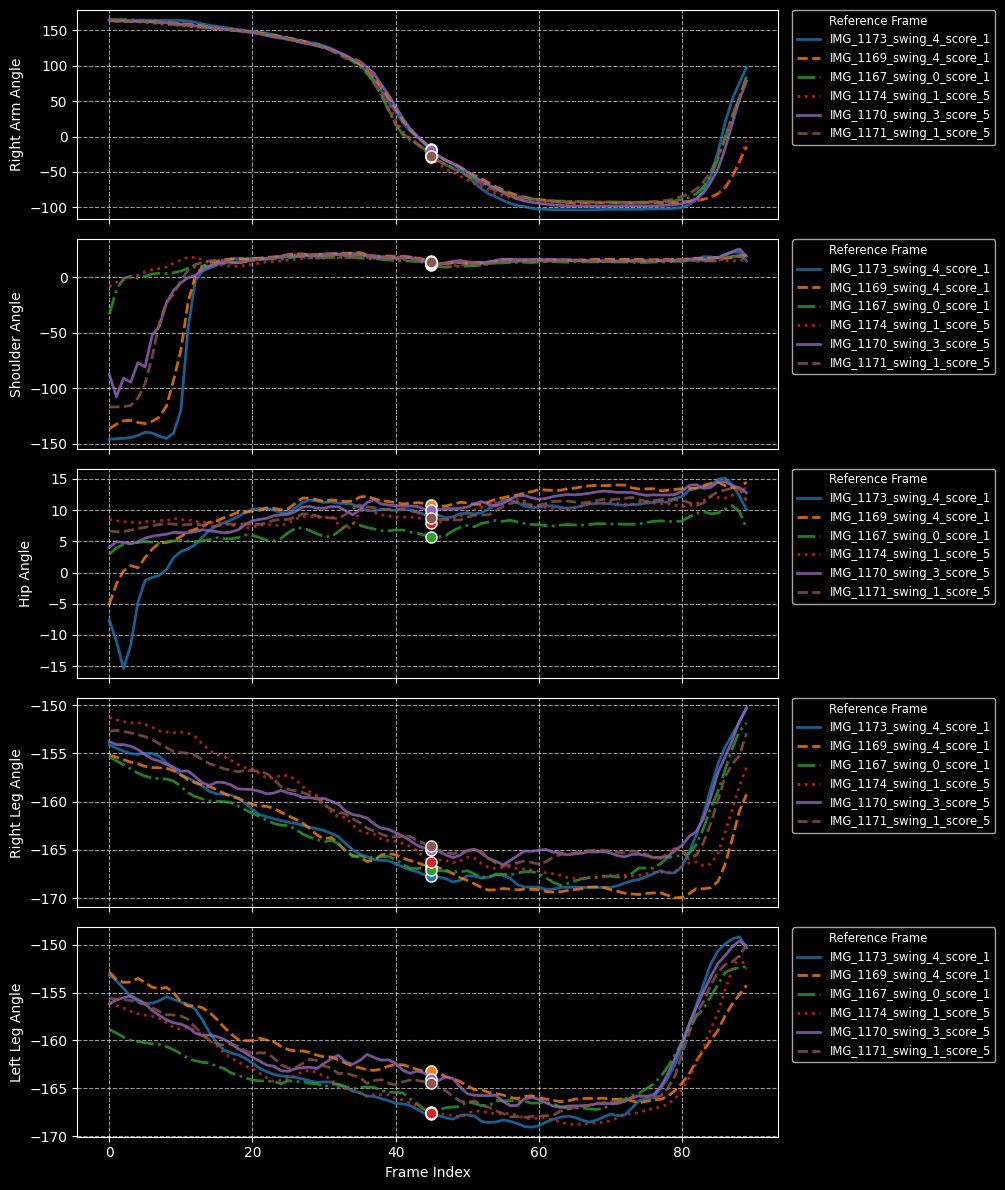

In [9]:
metrics_to_plot = angle_metrics
plot_swing_metrics(swing_objects[1:7], 
                   metrics_to_plot, 
                   labels=clip_names[1:7], 
                   highlight_frame=45)

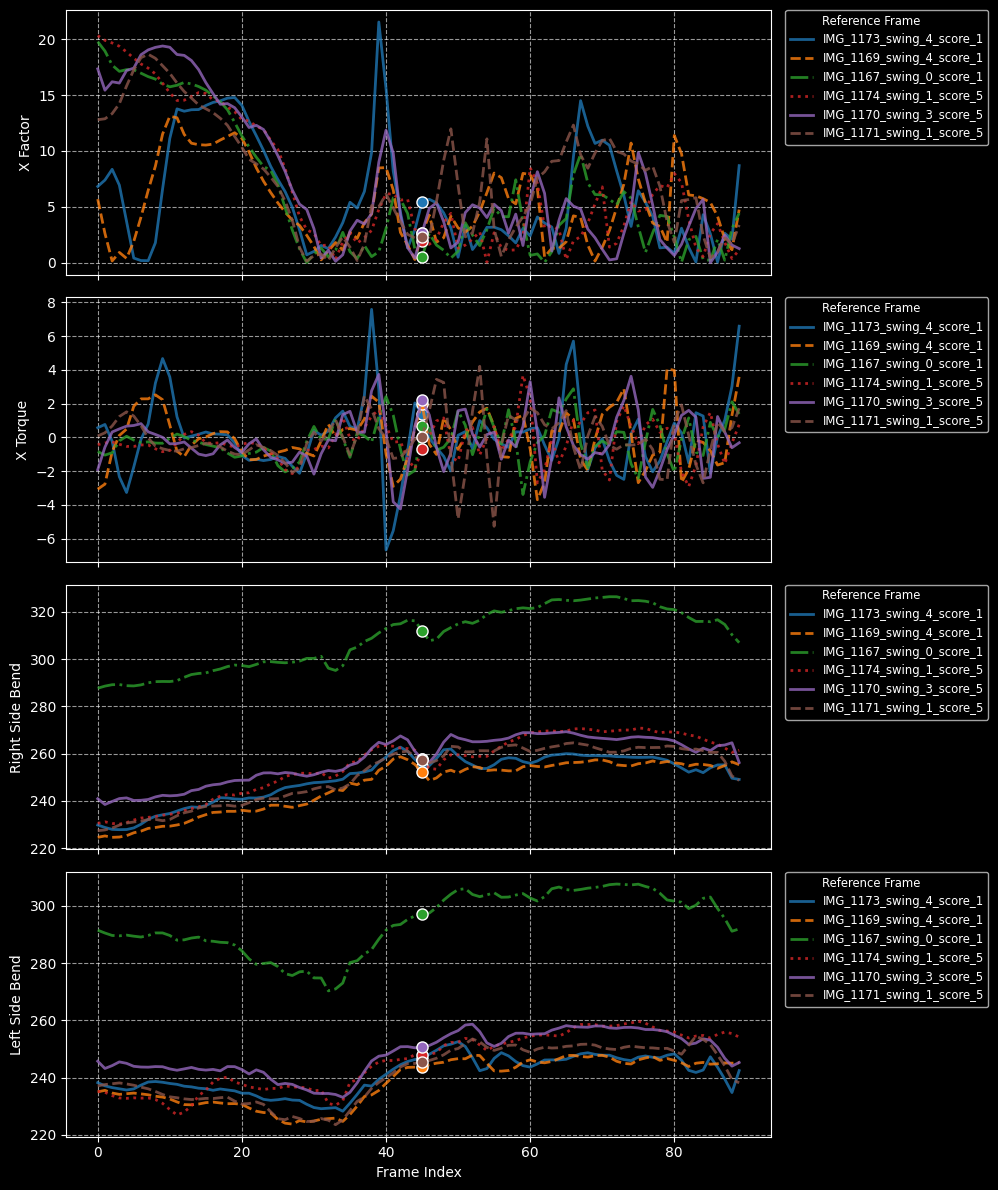

In [10]:
metrics_to_plot = misc_metrics
plot_swing_metrics(swing_objects[1:7], 
                   metrics_to_plot, 
                   labels=clip_names[1:7], 
                   highlight_frame=45)

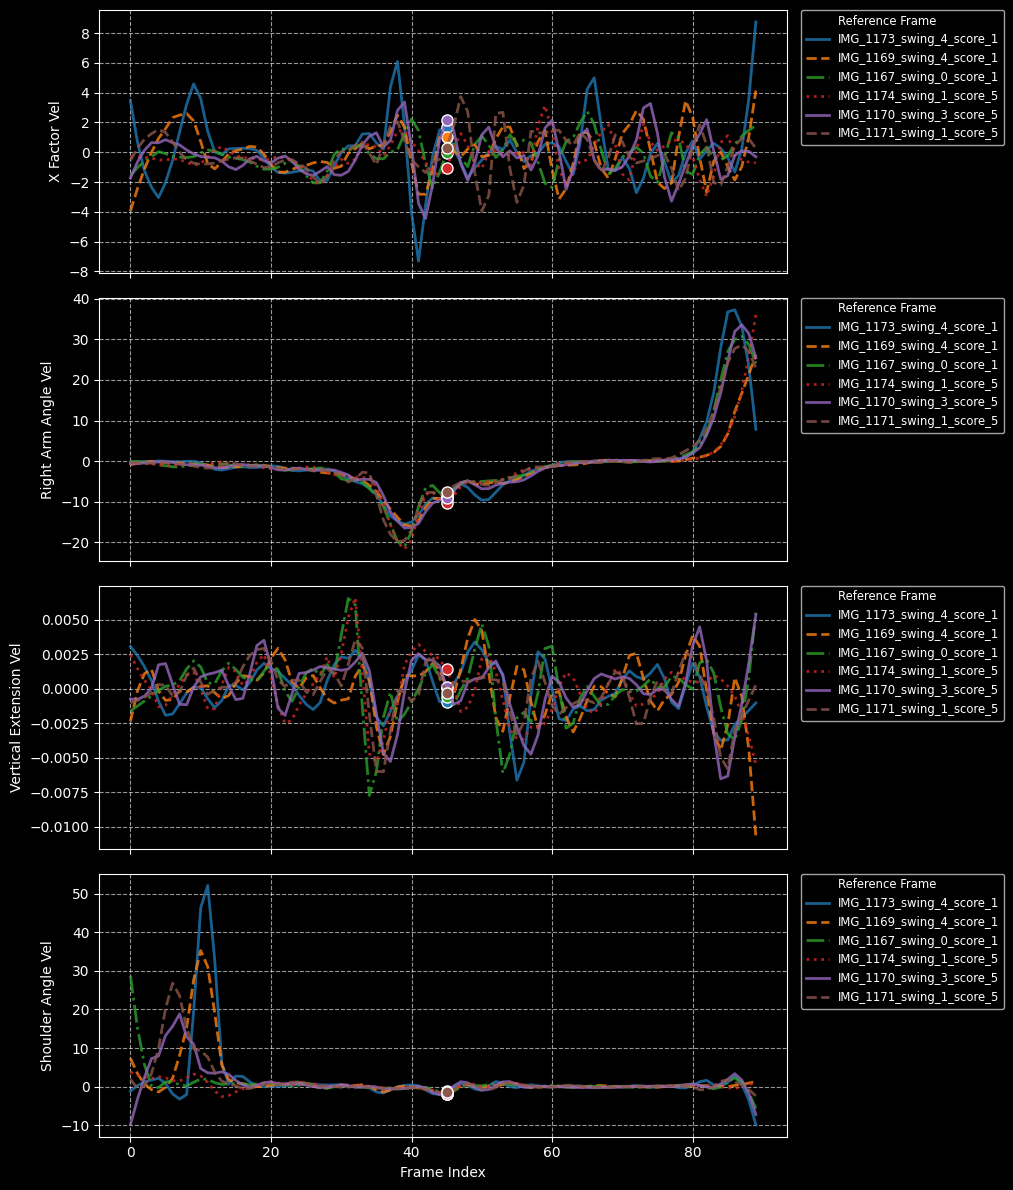

In [11]:
metrics_to_plot = vel_metrics
plot_swing_metrics(swing_objects[1:7], 
                   metrics_to_plot, 
                   labels=clip_names[1:7], 
                   highlight_frame=45)

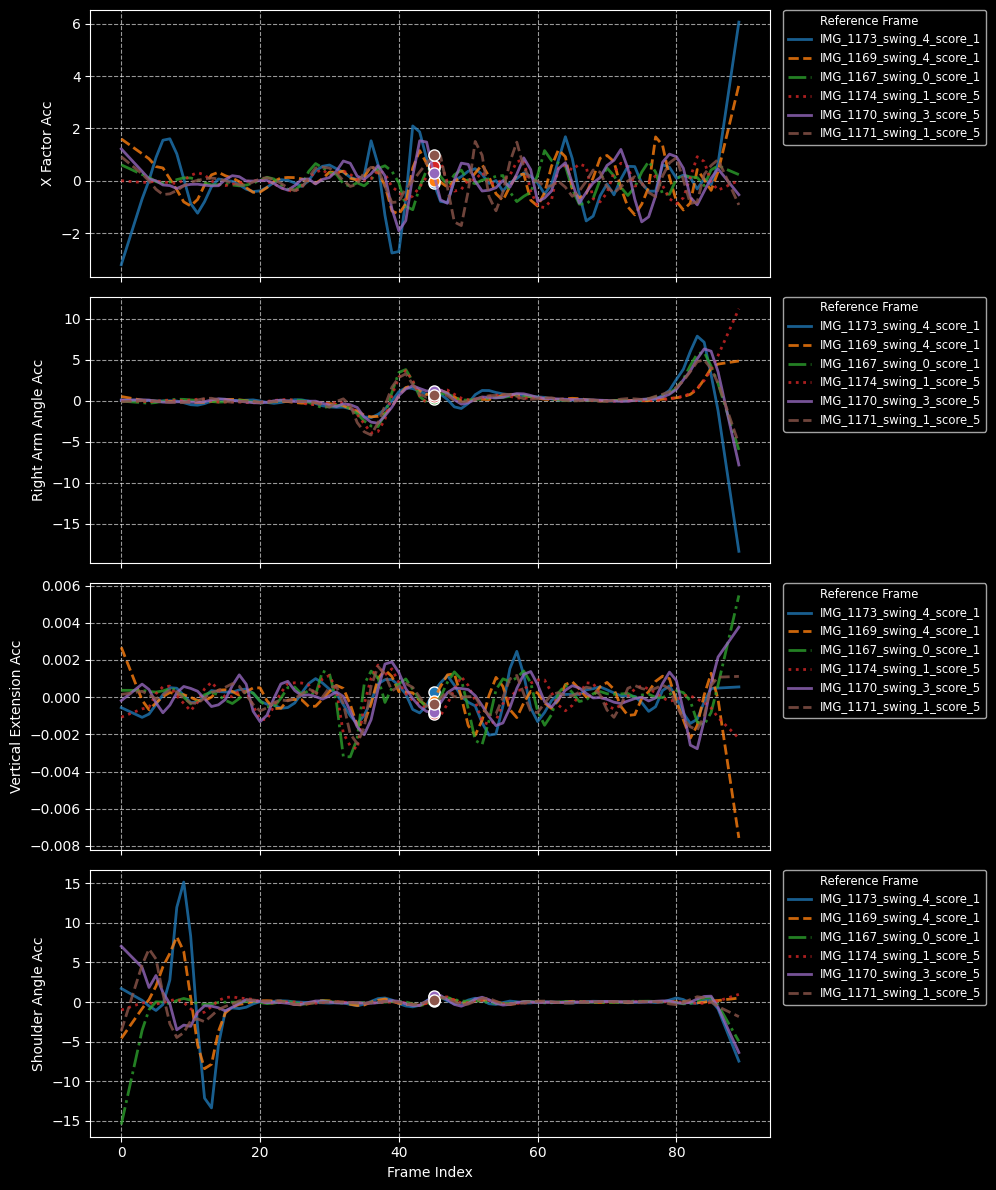

In [33]:
metrics_to_plot = acc_metrics
plot_swing_metrics(swing_objects[1:7], 
                   metrics_to_plot, 
                   labels=clip_names[1:7], 
                   highlight_frame=45)

1. Side Bend (Lateral Flexion)
This is the exact metric for "distance from hip to shoulder."
What it is: The contraction of the obliques on one side and lengthening on the other.
The Metric: Calculate the Euclidean distance between the shoulder (acromion) and the hip (iliac crest) on both the lead and trail sides.
Kinematic Pattern:
Address: Distances are roughly equal.
Top of Backswing: The lead side (left for right-handers) should contract slightly (dipping the shoulder), decreasing the distance.​
Impact: The trail side (right side) contracts significantly ("side crunch"), while the lead side extends fully.
Why it matters: Failure to shorten the trail side distance usually indicates "early extension" (standing up too straight) or a slide, causing a loss of posture.


2. Vertical Extension (The "Jump")
This measures the vertical separation of the body from the ground.
What it is: The golfer pushing off the ground to generate vertical ground reaction forces (GRF).
The Metric: Track the vertical (y-axis) distance of the Mid-Hip or Mid-Shoulder point relative to the ankles.
Kinematic Pattern: The distance should drop (compress) during the transition (squatting motion) and then rapidly increase (separate) just before impact.​
Why it matters: This "squat-then-jump" pattern is highly correlated with clubhead speed. If you only track rotation (angles), you miss this power source entirely.


3. Swing Radius (Width)
What it is: How "wide" the swing is.
The Metric: The distance between the hands/wrists and the chest center (sternum).
Kinematic Pattern: You want this distance to be maximized during the backswing (width) and maintained or managed during the downswing. Collapsing this distance usually means the arms are bending too much or the body is outracing the arms

In [69]:
# idxZ = row.first_highest_wrist_idx
# #mp4_path = 
# #get_frames(row.pkl
# video_path = f'{row.pkl_path[:-3]}mp4'
# frames = get_frames(video_path, start_idx=idxZ-90, num_frames=180)


In [12]:
rows = []
for idx, row in df_low_high.iterrows():
    rows.append(row)

In [22]:
kps_holder = [KpExtractor(row.pkl_path).kps[row.start_idx: row.end_idx+30] for row in rows] #if row.video_name == 'IMG_1167']
#kps_holder.shape

In [216]:
#rows[3]

In [14]:
frames, fps = get_frames(f"{rows[3].pkl_path[:-3]}mp4", num_frames=None)
frames.shape

100%|█████████████████████████████████████████████████████████| 5824/5824 [00:10<00:00, 572.22it/s]


(5824, 256, 256, 3)

In [15]:
%matplotlib widget
animate_keypoints_interactive(kps_holder[:], vertical=False,
                              dark_mode=True, )
                             #labels=lbls)
#display(HTML(animator.to_jshtml()))

Tempo:
    - Address --> top of backswing
    - top of backswing --> impact (????) -- are you decellerating  
    - 

In [23]:
end_downswing = [find_last_frame_wrist_is_right(kps) for kps in kps_holder]
top_of_swing_idx = [find_last_frame_before_downswing(kps) for kps in kps_holder]

In [27]:
scores = [row.score for row in rows]
scores

[1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5]

In [28]:
downswing_timing = np.array(end_downswing) - np.array(top_of_swing_idx)
downswing_timing

array([28, 29, 28, 28, 29, 30, 29, 27, 31, 29, 28, 31, 30])

In [31]:
speed_df = pd.DataFrame(zip(scores, downswing_timing), columns=['score','speed'])
speed_df.head(5)

,score,speed
0,1,28
1,1,29
2,1,28
3,1,28
4,5,29


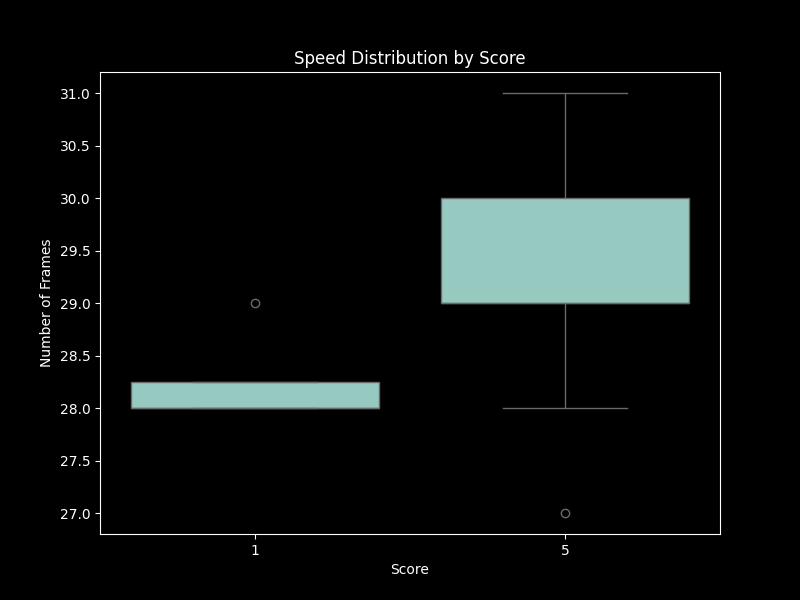

In [34]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.boxplot(data=speed_df, x='score', y='speed')

# 3. Add labels and title for context (Optional)
plt.title('Speed Distribution by Score')
plt.xlabel('Score')
plt.ylabel('Number of Frames')

# 4. Display the plot
plt.show()

In [16]:
[find_last_frame_wrist_is_right(kps) for kps in kps_holder]

NameError: name 'find_last_frame_wrist_is_right' is not defined

In [17]:
[find_last_frame_before_downswing(kps) for kps in kps_holder]

NameError: name 'find_last_frame_before_downswing' is not defined

In [1]:
#[find_last_frame_right_hand_crosses_left_body(kps) for kps in kps_holder]

In [1]:
def get_signed_distance(p_hand, p_shoulder, p_hip):
    """
    Returns > 0 if hand is to the RIGHT of the shoulder-hip line.
    Returns < 0 if hand is to the LEFT of the shoulder-hip line.
    Uses a vertical boundary when the hand is above the shoulder.
    """
    x_h, y_h = p_hand[:2]
    x_s, y_s = p_shoulder[:2]
    x_hip, y_hip = p_hip[:2]
    
    # 1. Vertical Projection Fix:
    # If hand is above the shoulder (y_h < y_s in image coords), 
    # use the shoulder's X as the vertical boundary.
    if y_h < y_s:
        return x_h - x_s

    # 2. Standard Line Projection (Below Shoulder):
    # Avoid division by zero
    if abs(y_hip - y_s) < 1e-6: 
        return x_h - x_s 
        
    # Calculate x of the body line at the hand's y-coordinate
    slope_inv = (x_hip - x_s) / (y_hip - y_s)
    x_line_at_hand_y = x_s + (y_h - y_s) * slope_inv
    
    return x_h - x_line_at_hand_y


def find_crossing_frames(keypoints):
    """
    Identifies frames where hands cross body lines in a specific direction (Right -> Left).
    
    Args:
        keypoints: Numpy array of shape (num_frames, num_kps, 2)
    
    Returns:
        dict: Lists of frame indices where the crossing event completes.
    """
    # COCO Indices
    L_SHOULDER, L_HIP = 5, 11
    R_SHOULDER, R_HIP = 6, 12
    L_HAND, R_HAND = 9, 10  # Using Wrists as proxies for Hands

    events = {
        'right_hand_crosses_left_body': [], # Right Hand crossing Left Body Line
        'left_hand_crosses_right_body': []  # Left Hand crossing Right Body Line
    } 
    holder = []
    # Iterate through frames
    for t in range(len(keypoints) - 1):
        kp_curr = keypoints[t]
        kp_next = keypoints[t+1]

        # --- Check 1: Right Hand crossing Left Body Line (Right -> Left) ---
        dist_curr = get_signed_distance(kp_curr[R_HAND], kp_curr[L_SHOULDER], kp_curr[L_HIP])
        dist_next = get_signed_distance(kp_next[R_HAND], kp_next[L_SHOULDER], kp_next[L_HIP])
        
        # Check for transition from Positive (Right) to Negative (Left)
        if dist_curr > 0 and dist_next <= 0:
            events['right_hand_crosses_left_body'].append(t + 1)
            holder.append(t)

        # --- Check 2: Left Hand crossing Right Body Line (Right -> Left) ---
        dist_curr_l = get_signed_distance(kp_curr[L_HAND], kp_curr[R_SHOULDER], kp_curr[R_HIP])
        dist_next_l = get_signed_distance(kp_next[L_HAND], kp_next[R_SHOULDER], kp_next[R_HIP])
        
        # Check for transition from Positive (Right) to Negative (Left)
        if dist_curr_l > 0 and dist_next_l <= 0:
            events['left_hand_crosses_right_body'].append(t + 1)

    events['time_between_crossing'] = holder[1] - holder[0]

    return events